# Comparison of Edge-Based Voronoi Implementations

This notebook compares the three different implementations:
1. **test_edge_voronoi.py** - Grid-based with OpenCV
2. **edge_voronoi_exact.py** - Class-based with exact and approximate methods
3. **voronoi_edge_polygons.py** - Module utility functions

## What is Edge-Based Voronoi?

Unlike traditional Voronoi diagrams where sites are points, **edge-based Voronoi diagrams** use line segments as sites. Each Voronoi cell contains all points that are closer to a particular edge than to any other edge.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# Import all three implementations
from test_edge_voronoi import (
    compute_edge_voronoi_polygons as compute_grid_based,
    polygons_to_edges
)

from analytic_inr.edge_voronoi_exact import EdgeVoronoiDiagram

from analytic_inr.voronoi_edge_polygons import (
    compute_edge_voronoi_polygons as compute_module_grid,
)

print("✓ All modules imported successfully!")


✓ All modules imported successfully!


## Create Test Shapes

Let's create some test polygons and convert them to edges:


Created 3 polygons → 12 edges


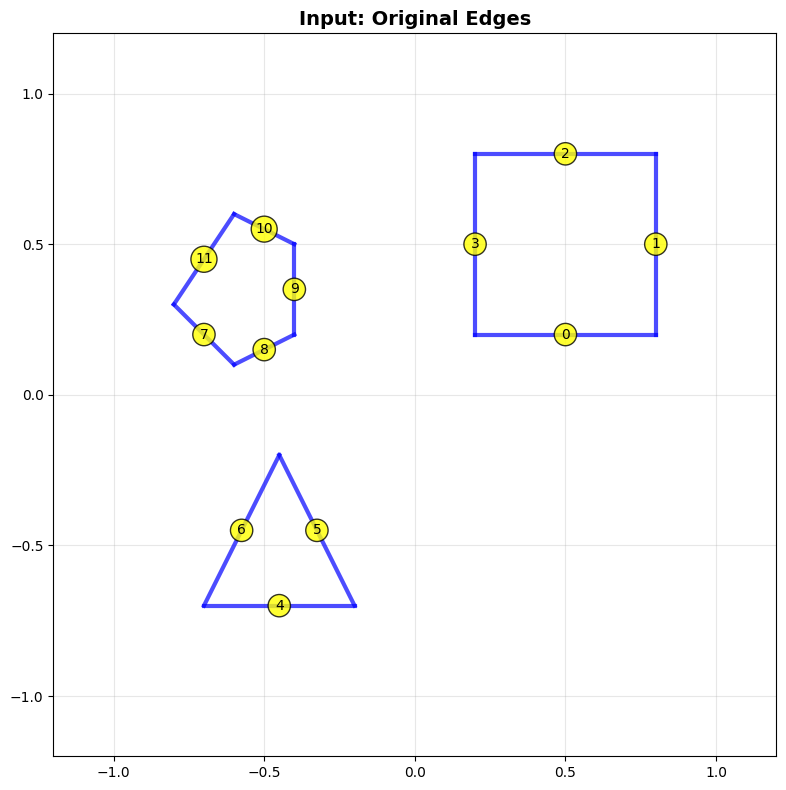

In [2]:
# Create test polygons
square = torch.tensor([
    [0.2, 0.2],
    [0.8, 0.2],
    [0.8, 0.8],
    [0.2, 0.8]
], dtype=torch.float32)

triangle = torch.tensor([
    [-0.7, -0.7],
    [-0.2, -0.7],
    [-0.45, -0.2]
], dtype=torch.float32)

pentagon = torch.tensor([
    [-0.8, 0.3],
    [-0.6, 0.1],
    [-0.4, 0.2],
    [-0.4, 0.5],
    [-0.6, 0.6]
], dtype=torch.float32)

polygons = [square, triangle, pentagon]
edges = polygons_to_edges(polygons)

print(f"Created {len(polygons)} polygons → {len(edges)} edges")

# Visualize the input
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Input: Original Edges", fontsize=14, fontweight='bold')

colors = plt.cm.tab20(np.linspace(0, 1, len(edges)))

for i, (start, end) in enumerate(edges):
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], 
            'b-', linewidth=3, alpha=0.7)
    mid = (start_np + end_np) / 2
    ax.text(mid[0], mid[1], str(i), fontsize=10, 
            ha='center', va='center', 
            bbox=dict(boxstyle='circle', facecolor='yellow', alpha=0.8))

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
for 

tensor([[0.2000, 0.2000],
        [0.8000, 0.2000],
        [0.8000, 0.8000],
        [0.2000, 0.8000]])

## Method 1: test_edge_voronoi.py

**Description:** Grid-based distance computation with OpenCV contour extraction
- Creates a grid of points
- Computes distance from each point to each edge
- Labels each point by nearest edge
- Extracts polygon contours using OpenCV


In [3]:
print("Running Method 1: test_edge_voronoi.py")
print("-" * 60)

start_time = time.time()
result1 = compute_grid_based(edges, grid_resolution=400, bounds=(-1, 1))
time1 = time.time() - start_time

print(f"✓ Completed in {time1:.3f}s")
print(f"✓ Found {len(result1['polygons'])} Voronoi polygons")
for i, (poly, edge_idx) in enumerate(zip(result1['polygons'], result1['edge_indices'])):
    print(f"  - Polygon {i}: Edge {edge_idx}, {len(poly)} vertices")


Running Method 1: test_edge_voronoi.py
------------------------------------------------------------
✓ Completed in 0.032s
✓ Found 12 Voronoi polygons
  - Polygon 0: Edge 0, 27 vertices
  - Polygon 1: Edge 1, 6 vertices
  - Polygon 2: Edge 2, 6 vertices
  - Polygon 3: Edge 3, 20 vertices
  - Polygon 4: Edge 4, 8 vertices
  - Polygon 5: Edge 5, 8 vertices
  - Polygon 6: Edge 6, 7 vertices
  - Polygon 7: Edge 7, 7 vertices
  - Polygon 8: Edge 8, 8 vertices
  - Polygon 9: Edge 9, 9 vertices
  - Polygon 10: Edge 10, 7 vertices
  - Polygon 11: Edge 11, 6 vertices


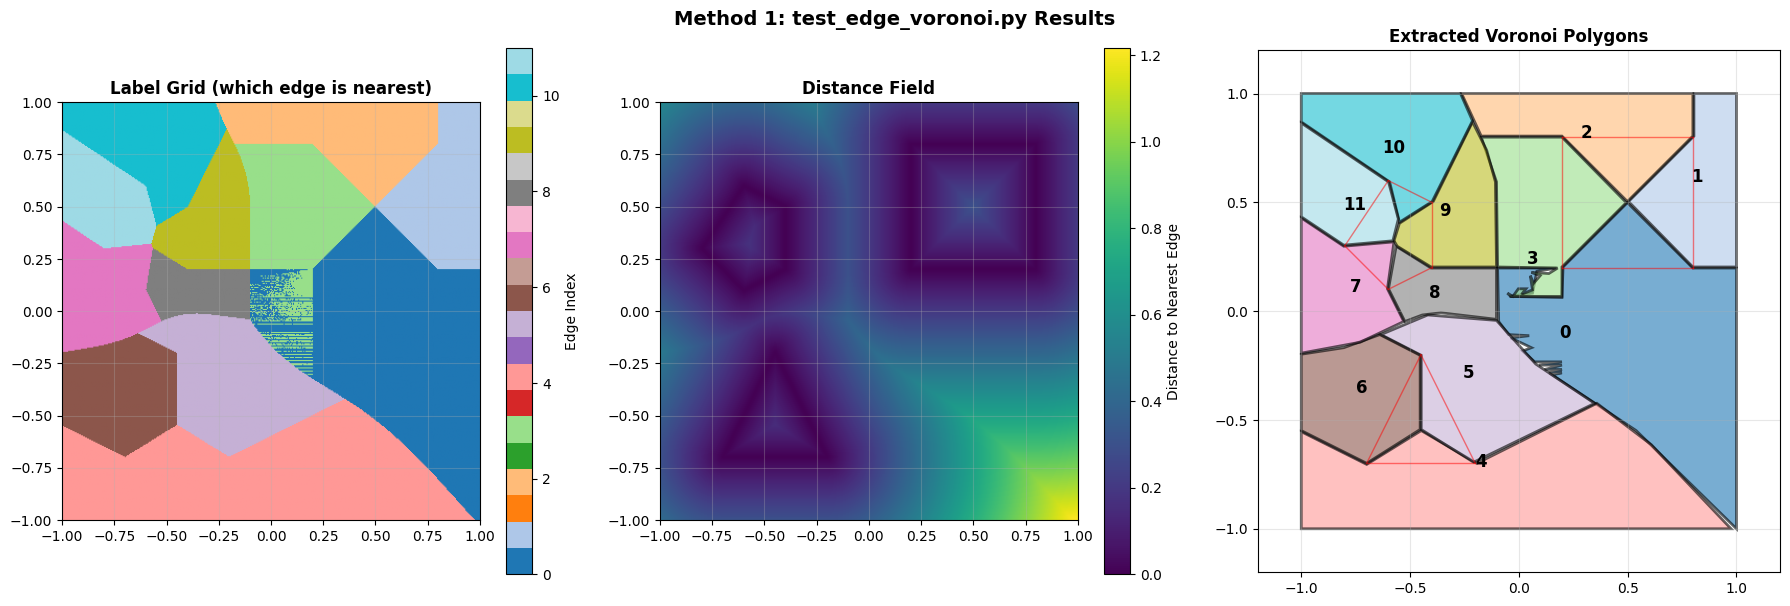

In [4]:
# Visualize Method 1 results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Label grid
ax1.set_title("Label Grid (which edge is nearest)", fontweight='bold')
im = ax1.imshow(result1['voronoi_labels'].cpu().numpy(), 
                cmap='tab20', origin='lower', extent=[-1, 1, -1, 1])
plt.colorbar(im, ax=ax1, label='Edge Index')
ax1.grid(True, alpha=0.3)

# Distance field
ax2.set_title("Distance Field", fontweight='bold')
im = ax2.imshow(result1['distances'].cpu().numpy(), 
                cmap='viridis', origin='lower', extent=[-1, 1, -1, 1])
plt.colorbar(im, ax=ax2, label='Distance to Nearest Edge')
ax2.grid(True, alpha=0.3)

# Extracted polygons
ax3.set_title("Extracted Voronoi Polygons", fontweight='bold')
for polygon, edge_idx in zip(result1['polygons'], result1['edge_indices']):
    poly_np = polygon.cpu().numpy()
    patch = patches.Polygon(poly_np, closed=True, alpha=0.6,
                           facecolor=colors[edge_idx % len(colors)],
                           edgecolor='black', linewidth=2)
    ax3.add_patch(patch)
    centroid = poly_np.mean(axis=0)
    ax3.text(centroid[0], centroid[1], str(edge_idx),
            ha='center', va='center', fontsize=12, fontweight='bold')

# Overlay original edges
for start, end in edges:
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    ax3.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], 
            'r-', linewidth=1, alpha=0.5)

ax3.set_xlim(-1.2, 1.2)
ax3.set_ylim(-1.2, 1.2)
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)

plt.suptitle("Method 1: test_edge_voronoi.py Results", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Method 2a: edge_voronoi_exact.py - Exact (Grid-based)

**Description:** Class-based implementation using the same grid approach as Method 1
- Wrapped in an `EdgeVoronoiDiagram` class
- Provides OOP interface with visualization methods
- Essentially the same algorithm as Method 1


Running Method 2a: edge_voronoi_exact.py (exact)
------------------------------------------------------------
✓ Completed in 0.022s
✓ Found 12 Voronoi polygons
  - Polygon 0: 44 vertices
  - Polygon 1: 6 vertices
  - Polygon 2: 7 vertices
  - Polygon 3: 39 vertices
  - Polygon 4: 8 vertices
  - Polygon 5: 12 vertices
  - Polygon 6: 8 vertices
  - Polygon 7: 10 vertices
  - Polygon 8: 36 vertices
  - Polygon 9: 12 vertices
  - Polygon 10: 9 vertices
  - Polygon 11: 11 vertices


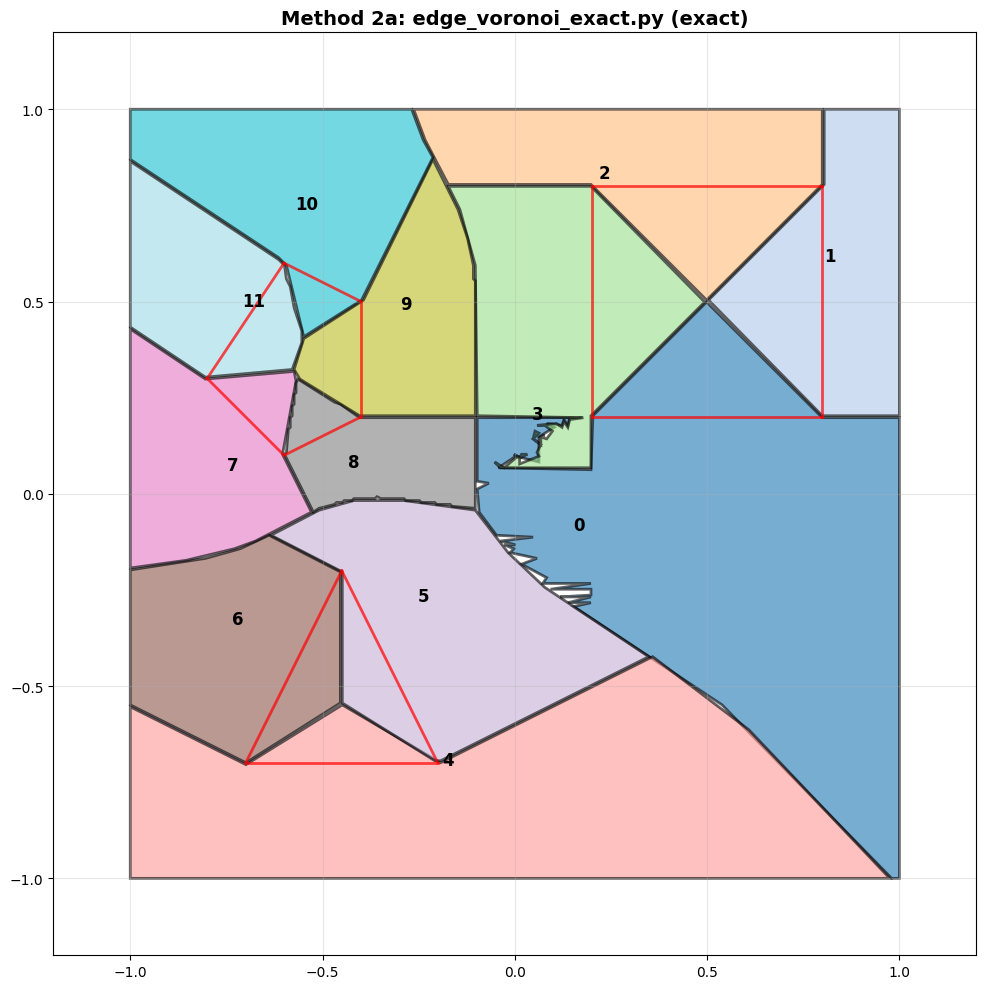

In [5]:
print("Running Method 2a: edge_voronoi_exact.py (exact)")
print("-" * 60)

start_time = time.time()
evd_exact = EdgeVoronoiDiagram(edges, bounds=(-1, 1, -1, 1))
result2a = evd_exact.compute_exact(resolution=400)
time2a = time.time() - start_time

print(f"✓ Completed in {time2a:.3f}s")
print(f"✓ Found {len(result2a)} Voronoi polygons")
for i, poly in enumerate(result2a):
    print(f"  - Polygon {i}: {len(poly)} vertices")

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Method 2a: edge_voronoi_exact.py (exact)", fontsize=14, fontweight='bold')

for poly_idx, polygon in enumerate(result2a):
    # Find which edge this polygon belongs to
    edge_idx = None
    for e_idx, p_idx in evd_exact.edge_to_polygon.items():
        if p_idx == poly_idx:
            edge_idx = e_idx
            break
    
    if edge_idx is not None:
        poly_np = polygon.numpy() if torch.is_tensor(polygon) else polygon
        patch = patches.Polygon(poly_np, closed=True, alpha=0.6,
                               facecolor=colors[edge_idx % len(colors)],
                               edgecolor='black', linewidth=2)
        ax.add_patch(patch)
        centroid = poly_np.mean(axis=0)
        ax.text(centroid[0], centroid[1], str(edge_idx),
                ha='center', va='center', fontsize=12, fontweight='bold')

# Overlay edges
for start, end in edges:
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], 
            'r-', linewidth=2, alpha=0.7)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Method 2b: edge_voronoi_exact.py - Approximation (Sampling)

**Description:** Samples many points along each edge, then uses point-based Voronoi
- Densely samples points on each edge
- Computes traditional point-based Voronoi diagram (scipy)
- Merges regions belonging to the same edge (shapely)
- **Slower** and **less accurate** than grid-based methods
- May miss thin regions


Running Method 2b: edge_voronoi_exact.py (approximation)
------------------------------------------------------------
✓ Completed in 0.111s
✓ Found 9 Voronoi polygons
  - Polygon 0: 135 vertices
  - Polygon 1: 120 vertices
  - Polygon 2: 175 vertices
  - Polygon 3: 130 vertices
  - Polygon 4: 133 vertices
  - Polygon 5: 113 vertices
  - Polygon 6: 162 vertices
  - Polygon 7: 126 vertices
  - Polygon 8: 144 vertices


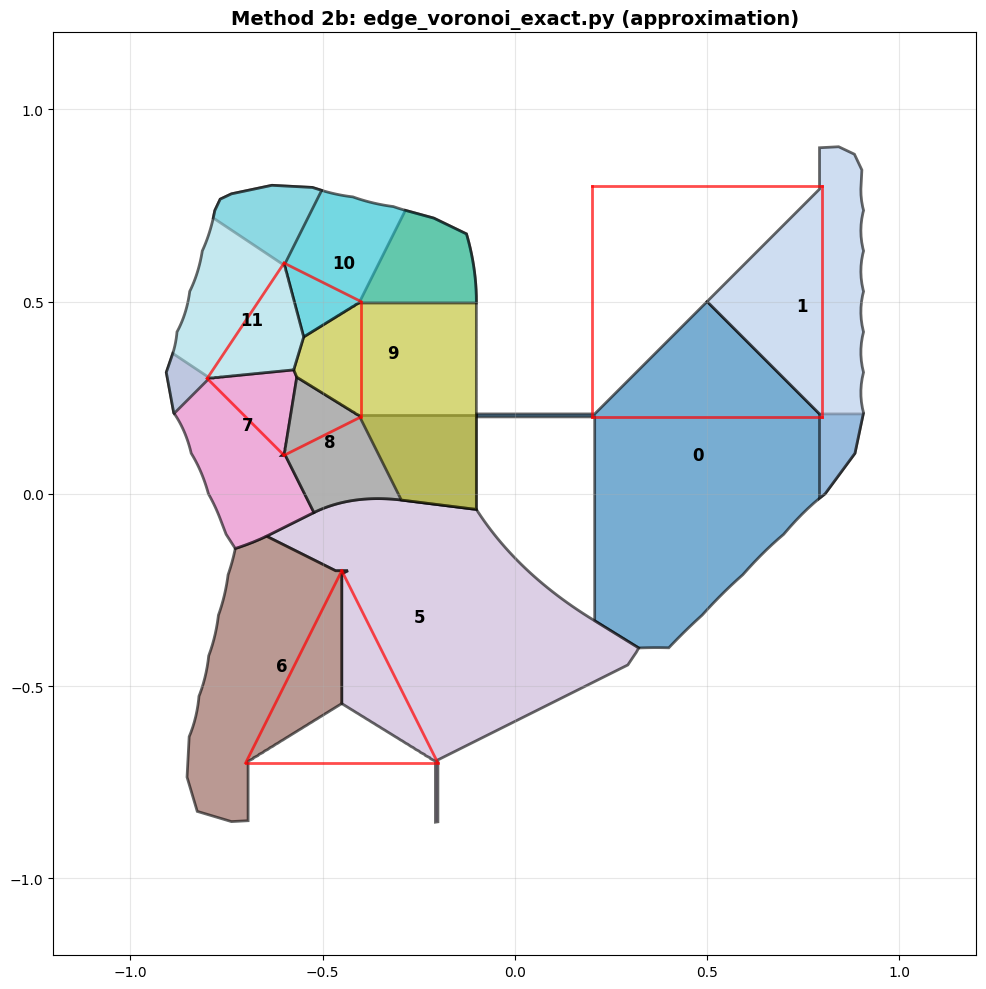

In [6]:
print("Running Method 2b: edge_voronoi_exact.py (approximation)")
print("-" * 60)

start_time = time.time()
evd_approx = EdgeVoronoiDiagram(edges, bounds=(-1, 1, -1, 1))
result2b = evd_approx.compute_approximation(samples_per_edge=40)
time2b = time.time() - start_time

print(f"✓ Completed in {time2b:.3f}s")
print(f"✓ Found {len(result2b)} Voronoi polygons")
for i, poly in enumerate(result2b):
    print(f"  - Polygon {i}: {len(poly)} vertices")

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Method 2b: edge_voronoi_exact.py (approximation)", fontsize=14, fontweight='bold')

for poly_idx, polygon in enumerate(result2b):
    # Find which edge this polygon belongs to
    edge_idx = None
    for e_idx, p_idx in evd_approx.edge_to_polygon.items():
        if p_idx == poly_idx:
            edge_idx = e_idx
            break
    
    if edge_idx is not None:
        poly_np = polygon if isinstance(polygon, np.ndarray) else polygon.numpy()
        patch = patches.Polygon(poly_np, closed=True, alpha=0.6,
                               facecolor=colors[edge_idx % len(colors)],
                               edgecolor='black', linewidth=2)
        ax.add_patch(patch)
        centroid = poly_np.mean(axis=0)
        ax.text(centroid[0], centroid[1], str(edge_idx),
                ha='center', va='center', fontsize=12, fontweight='bold')

# Overlay edges
for start, end in edges:
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], 
            'r-', linewidth=2, alpha=0.7)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Method 3: voronoi_edge_polygons.py

**Description:** Module-level functions using grid-based approach
- Similar algorithm to Method 1
- Provided as importable utility functions
- Best for integration into larger projects
- Lives in the `analytic_inr` module


Running Method 3: voronoi_edge_polygons.py
------------------------------------------------------------
✓ Completed in 0.026s
✓ Found 12 Voronoi polygons
  - Polygon 0: Edge 0, 16 vertices
  - Polygon 1: Edge 1, 6 vertices
  - Polygon 2: Edge 2, 6 vertices
  - Polygon 3: Edge 3, 14 vertices
  - Polygon 4: Edge 4, 7 vertices
  - Polygon 5: Edge 5, 8 vertices
  - Polygon 6: Edge 6, 6 vertices
  - Polygon 7: Edge 7, 7 vertices
  - Polygon 8: Edge 8, 7 vertices
  - Polygon 9: Edge 9, 7 vertices
  - Polygon 10: Edge 10, 7 vertices
  - Polygon 11: Edge 11, 6 vertices


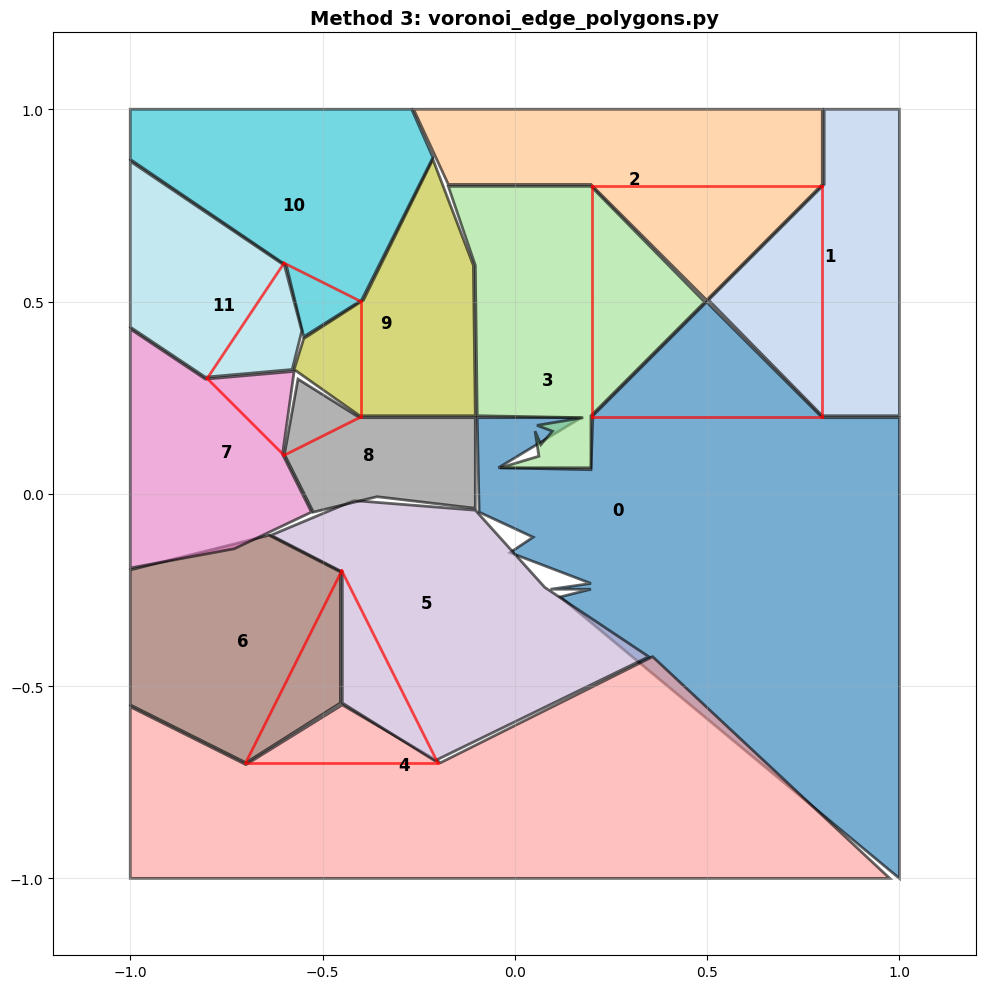

In [7]:
print("Running Method 3: voronoi_edge_polygons.py")
print("-" * 60)

start_time = time.time()
result3 = compute_module_grid(edges, grid_resolution=400, bounds=(-1, 1))
time3 = time.time() - start_time

print(f"✓ Completed in {time3:.3f}s")
print(f"✓ Found {len(result3['polygons'])} Voronoi polygons")
for i, (poly, edge_idx) in enumerate(zip(result3['polygons'], result3['edge_indices'])):
    print(f"  - Polygon {i}: Edge {edge_idx}, {len(poly)} vertices")

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Method 3: voronoi_edge_polygons.py", fontsize=14, fontweight='bold')

for polygon, edge_idx in zip(result3['polygons'], result3['edge_indices']):
    poly_np = polygon.cpu().numpy()
    patch = patches.Polygon(poly_np, closed=True, alpha=0.6,
                           facecolor=colors[edge_idx % len(colors)],
                           edgecolor='black', linewidth=2)
    ax.add_patch(patch)
    centroid = poly_np.mean(axis=0)
    ax.text(centroid[0], centroid[1], str(edge_idx),
            ha='center', va='center', fontsize=12, fontweight='bold')

# Overlay edges
for start, end in edges:
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], 
            'r-', linewidth=2, alpha=0.7)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Side-by-Side Comparison

Let's compare all methods in one plot:


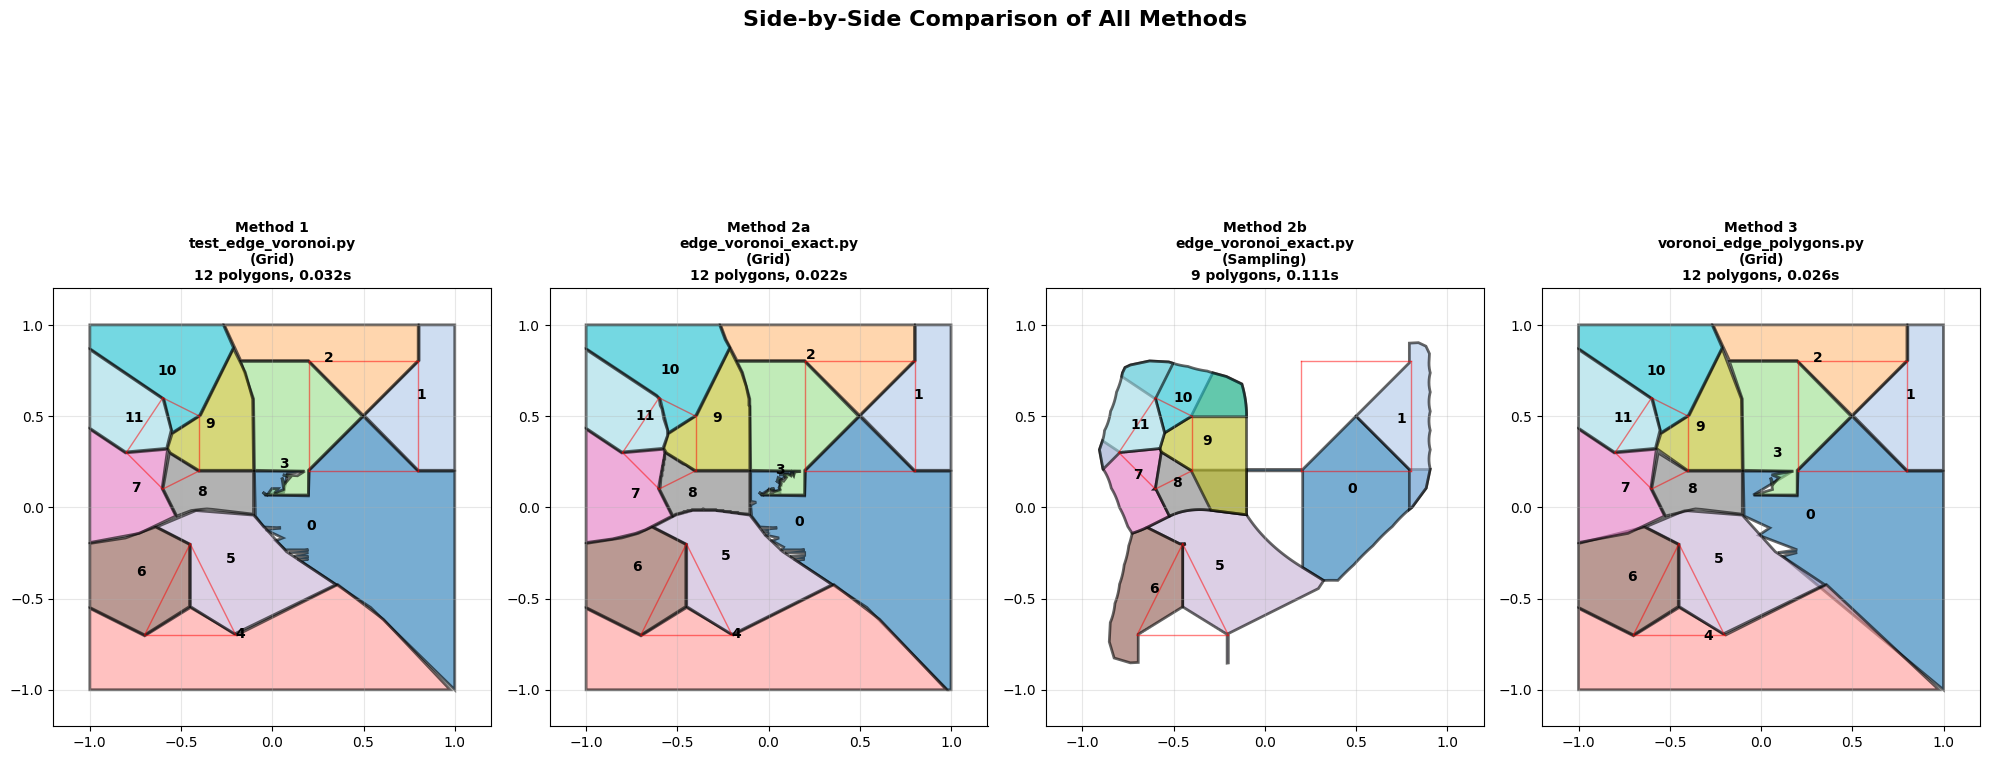

In [8]:
fig = plt.figure(figsize=(20, 10))

# Create a side-by-side comparison
methods = [
    ("Method 1\ntest_edge_voronoi.py\n(Grid)", result1['polygons'], result1['edge_indices'], time1),
    ("Method 2a\nedge_voronoi_exact.py\n(Grid)", result2a, 
     [e for e, p in sorted(evd_exact.edge_to_polygon.items(), key=lambda x: x[1])], time2a),
    ("Method 2b\nedge_voronoi_exact.py\n(Sampling)", result2b, 
     [e for e, p in sorted(evd_approx.edge_to_polygon.items(), key=lambda x: x[1])], time2b),
    ("Method 3\nvoronoi_edge_polygons.py\n(Grid)", result3['polygons'], result3['edge_indices'], time3)
]

for idx, (title, polygons, indices, exec_time) in enumerate(methods):
    ax = plt.subplot(1, 4, idx + 1)
    ax.set_title(f"{title}\n{len(polygons)} polygons, {exec_time:.3f}s", 
                 fontsize=10, fontweight='bold')
    
    # Plot polygons
    for poly_idx, polygon in enumerate(polygons):
        edge_idx = indices[poly_idx] if poly_idx < len(indices) else 0
        poly_np = polygon.numpy() if torch.is_tensor(polygon) else polygon
        
        patch = patches.Polygon(poly_np, closed=True, alpha=0.6,
                               facecolor=colors[edge_idx % len(colors)],
                               edgecolor='black', linewidth=2)
        ax.add_patch(patch)
        
        centroid = poly_np.mean(axis=0)
        ax.text(centroid[0], centroid[1], str(edge_idx),
                ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Overlay edges
    for start, end in edges:
        start_np = start.cpu().numpy()
        end_np = end.cpu().numpy()
        ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], 
                'r-', linewidth=1, alpha=0.5)
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle("Side-by-Side Comparison of All Methods", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Summary & Conclusions

### What Each File Does:

1. **test_edge_voronoi.py**
   - Standalone test script with grid-based implementation
   - Best for: Quick testing and demonstrations
   - Has built-in test cases and visualization

2. **edge_voronoi_exact.py**
   - Class-based with TWO methods:
     - `compute_exact()` - Grid-based (like #1)
     - `compute_approximation()` - Sampling-based with scipy/shapely
   - Best for: When you need both approaches or OOP interface

3. **voronoi_edge_polygons.py**
   - Module with utility functions
   - Similar to #1 but as importable functions
   - Best for: Integration into larger projects
   - Already in the `analytic_inr` module

### Which One To Use?

- **All grid-based methods (1, 2a, 3)** give nearly **identical results**
- The **sampling method (2b)** is **slower and less accurate**
- **Recommendation**: Use `voronoi_edge_polygons.py` for production code
  - It's already in the `analytic_inr` module
  - Clean, functional interface
  - Fast and accurate

### Performance Summary:


In [9]:
print("=" * 80)
print("PERFORMANCE COMPARISON")
print("=" * 80)
print(f"Method 1 (test_edge_voronoi.py):          {time1:.4f}s - {len(result1['polygons'])} polygons")
print(f"Method 2a (edge_voronoi_exact - grid):    {time2a:.4f}s - {len(result2a)} polygons")
print(f"Method 2b (edge_voronoi_exact - sampling): {time2b:.4f}s - {len(result2b)} polygons")
print(f"Method 3 (voronoi_edge_polygons.py):      {time3:.4f}s - {len(result3['polygons'])} polygons")
print("=" * 80)
print()
print("CONCLUSION:")
print("  Grid-based methods (1, 2a, 3) are fastest and most accurate.")
print("  They all produce essentially the same results.")
print("  Use voronoi_edge_polygons.py for production code.")
print("=" * 80)


PERFORMANCE COMPARISON
Method 1 (test_edge_voronoi.py):          0.0322s - 12 polygons
Method 2a (edge_voronoi_exact - grid):    0.0218s - 12 polygons
Method 2b (edge_voronoi_exact - sampling): 0.1110s - 9 polygons
Method 3 (voronoi_edge_polygons.py):      0.0261s - 12 polygons

CONCLUSION:
  Grid-based methods (1, 2a, 3) are fastest and most accurate.
  They all produce essentially the same results.
  Use voronoi_edge_polygons.py for production code.
